# Importation of packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

from sklearn.linear_model import LinearRegression

# Exercice 1

create_data

In [2]:
def create_data(nb_point, param_class_1, param_class_2):

  mean_x, mean_y, var_x, var_y = param_class_1
  xy_0, class_0 = create_class_i(mean_x, mean_y, var_x, var_y,0,nb_point)

  mean_x, mean_y, var_x, var_y = param_class_2
  xy_1, class_1 = create_class_i(mean_x, mean_y, var_x, var_y,1,nb_point)

  xy = np.hstack((xy_0,xy_1))
  class_ = np.hstack((class_0,class_1))

  return xy.transpose(), class_.reshape(-1,1)

In [3]:
def create_class_i(mean_x, mean_y, var_x, var_y, i, nb_point):

  x = np.random.normal(mean_x,var_x,nb_point)
  y = np.random.normal(mean_y,var_y,nb_point)

  xy = np.array([x,y])

  class_ = np.array(np.ones(nb_point)*i,int)

  return xy, class_

In [4]:
nb_point = 100
param_class_1 = (2,3,1,3)
param_class_2 = (5,6,0.5,2)
xy, categories = create_data(nb_point,param_class_1,param_class_2)

In [5]:
xy.shape

(200, 2)

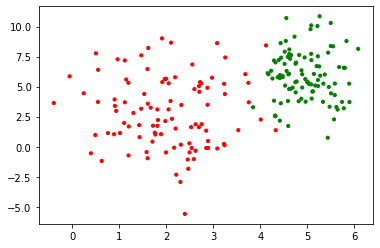

In [6]:
# use colormap
colormap = np.array(['r', 'g'])
  
# depict illustration
plt.scatter(xy.transpose()[0], xy.transpose()[1], s=10, c=colormap[categories].flatten())

## Resolution primal

Function to solve the primal

In [7]:
def SVC_primal(y,x, lambda_):
  # normalize z
  if np.min(y) == 0 :
    y = 2 * y
    y = y - 1

  # parameters
  n = xy.shape[0]
  d = xy.shape[1]

  # variables
  W = cvx.Variable(d)
  eps = cvx.Variable(n)

  b = cvx.Variable(1)

  # obj
  objective = cvx.Minimize(1/2*cvx.square(cvx.sum_squares(W)) + lambda_*cvx.sum(eps))

  # constraints
  constraints = [y[k] * (cvx.matmul(x[k,:].reshape((1,2)), W) + b) >= 1 - eps[k] for k in range(n)]

  for k in range(n):
    constraints.append(eps[k]>=0.0)
  
  # resolution
  probs = cvx.Problem(objective, constraints)
  result = probs.solve() 

  # value
  print("status:", probs.status)
  print("optimal value", probs.value)
  print("W \n",W.value)
  print("b \n",b.value)
  print("mean eps \n",np.mean(eps.value))

  return W.value, b.value, eps.value

Function to display the SVC

In [8]:
def plot_SVC(x,y, w, b):
  y = np.array(y >= np.mean(y),int)
  print(len(y))

  colormap = np.array(['r', 'g'])
  x_points = np.linspace(np.min(x.transpose()[0]), np.max(x.transpose()[0]))
  y_points = -(w[0] / w[1]) * x_points - b / w[1]

  plt.ylim(np.min(x.transpose()[1]),np.max(x.transpose()[1]))
  plt.xlim(np.min(x.transpose()[0]),np.max(x.transpose()[0]))

  plt.scatter(x.transpose()[0], x.transpose()[1], s=10, c=colormap[y].flatten())
  plt.plot(x_points.flatten(), y_points.flatten(), c='y');

Creation of data and train the SVC

In [9]:
xy, categories = create_data(100, param_class_1, param_class_2)

status: optimal
optimal value 432.4829664425064
W 
 [3.24127062 0.24897707]
b 
 [-13.12311244]
mean eps 
 0.0188321752621697
200


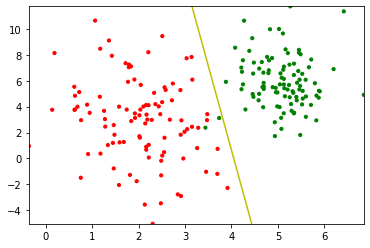

In [10]:
W, b, eps = SVC_primal(categories,xy, 100)
plot_SVC(xy,categories, W, b)

## Resolution with ridge regression

In [11]:
d = xy.shape[1]
lambda_ = 100
y = 2*categories-1 # to get -1 and  1

Recreation of the formula

In [12]:
intercept = np.ones(len(xy)).reshape(-1,1)

phi_first = np.sqrt(lambda_)*y*np.hstack((intercept,xy))
phi_second = 1/np.sqrt(2)*np.diag([0]+list(np.ones(d)))

phi = np.vstack((phi_first,phi_second))

In [13]:
y_ridge_first = np.sqrt(lambda_) * np.ones(len(xy))
y_ridge_second = np.zeros(len(phi_second))

y_ridge = np.hstack((y_ridge_first,y_ridge_second))

Regression of these variables to get b and W

In [14]:
model = LinearRegression()
model.fit(phi,y_ridge)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
print(model.coef_)
b = model.coef_[0]
W = model.coef_[1:3]

[-0.16967834  0.0417831   0.00481029]


Display of the hyperplane found

It seems that there is a little offset

200


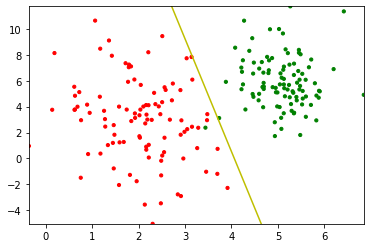

In [16]:
plot_SVC(xy,categories, W, b)

## Nearest centroids

Functions to get the centroids of the two classes and then say which more is the less distant

In [17]:
def calculate_centroids(x, y):
    return np.array([x[(y == i).flatten()].mean(axis=0) for i in range(2)])

def nearest_centroid_classifier(x, centroids):
  res_0 = np.linalg.norm(x - centroids[0], axis = 1)
  res_1 = np.linalg.norm(x - centroids[1], axis = 1)

  distances = np.array([res_0,res_1])

  return np.argmin(distances, axis = 0), distances

In [18]:
y = categories

Model of nearest centroids

In [19]:
centroids = calculate_centroids(xy, y)
print(centroids)
nearest_categories, distances = nearest_centroid_classifier(xy, centroids)

[[2.02733906 2.94344022]
 [5.07841246 5.88270269]]


Display of the original data

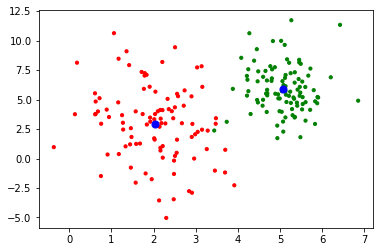

In [20]:
plt.scatter(xy.transpose()[0], xy.transpose()[1], s=10, c=colormap[categories].flatten())
plt.scatter(centroids[:,0], centroids[:,1],s=50, color = 'b')

Display of the prediction with the nearest centroids methods (not so good)

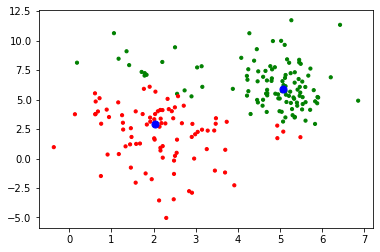

In [21]:
plt.scatter(xy.transpose()[0], xy.transpose()[1], s=10, c=colormap[nearest_categories].flatten())
plt.scatter(centroids[:,0], centroids[:,1],s=50, color = 'b')

# Exercice 2

Creation of the data

In [22]:
def create_data_cercle(center, r, born_inf, nb_points) :
    center = np.array(center)
    center_x = center[0] 
    center_y =  center[1]
    

    x = np.random.uniform(low = -r, high = r, size = nb_points)
    y = np.random.uniform(low = -np.sqrt(r*r - x*x),high = np.sqrt(r*r - x*x),size=nb_points)

    x+=center_x
    y+=center_y

    points = np.array([x,y]).transpose()

    norm = np.linalg.norm(points - center, axis = 1)
    res = norm > born_inf
    return points,np.array(res,int)

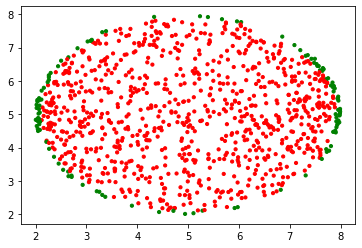

In [23]:
x,y = create_data_cercle([5,5],3, 2.9, 1000)
plt.scatter(x.transpose()[0], x.transpose()[1], s=10, c=colormap[y].flatten())

Test with nearest centroids

In [24]:
centroids = calculate_centroids(x, y)
print(centroids)
nearest_categories, distances = nearest_centroid_classifier(x, centroids)

[[5.02702988 5.00043241]
 [5.08252845 5.11834295]]


Display of the prediction for nearest centroids method

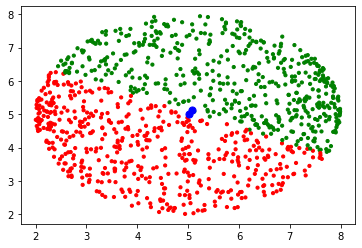

In [25]:
plt.scatter(x.transpose()[0], x.transpose()[1], s=10, c=colormap[nearest_categories].flatten())
plt.scatter(centroids[:,0], centroids[:,1],s=50, color = 'b')

Wold Dual with kernel

In [26]:
def normalize_y(y):
    if np.min(y) == 0 :
        y = y*2 - 1
    return y.reshape(y.shape[0],1)

Function that will be used for the quadratic form but DCP is not verified with this A

In [27]:
def creation_of_A(y,x,n,kernel):
    V = np.multiply(y,x).T # yi xi
    A = kernel(V,V)
    print(A[:5,:5])
    print(A.shape)
    return A

In [28]:
def define_constraints(y,alpha,lambda_,n):
    y = y.reshape((y.shape[0],))
    constraints = [cvx.sum(cvx.multiply(alpha,y))==0]
    for i in range(n):
        constraints += [alpha[i]>=0]
        constraints += [alpha[i]<=lambda_]
    return constraints

Main function of Wolfe Dual

In [29]:
def SVC_dual(y,x, lambda_, kernel):
  y = normalize_y(y)

  n = x.shape[0]
  d = x.shape[1]

  alpha = cvx.Variable(n)

  A = creation_of_A(y,x,n,kernel)
  print("Defined pos ?", is_pos_def(A))
  
  objective = cvx.Maximize(cvx.sum(alpha) - 1/2 *cvx.quad_form(alpha, A))

  constraints = define_constraints(y,alpha,lambda_,n)

  probs = cvx.Problem(objective, constraints)

  result = probs.solve() 
  print("status:", probs.status)
  print("optimal value", probs.value)


  alpha = alpha.value

  alpha = alpha.reshape((len(alpha),1))
  y = alpha.reshape((len(y),1))
  W = np.sum(np.multiply(alpha,np.multiply(y,x)),axis=0)
  b = np.sum(np.multiply(alpha,y))

  return W, b, alpha

In [30]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [31]:
def kernel_exp(x,y):
  sigma = 1
  return np.exp(-np.linalg.norm(x-y,axis=0)/(sigma**2))

In [32]:
def kernel_linear(x,y):
  A = x.T.dot(y)
  return A

Function to predict

In [33]:
def get_class_dual(x, alpha, y,x_hist,b, kernel):
  y = normalize_y(y)
  return np.sum(alpha*y*kernel(x,x_hist)) + b > 0

It is not good for now, I will try to find how kernel has to change the code and if the model really works for also a linear kerner and exp kernel.

In [34]:
x,y = create_data_cercle([5,5],3,2,200)
W, b, alpha = SVC_dual(y,x,10, kernel_linear)

[[ 31.34771583 -37.01165165 -50.4922988  -50.23787009 -31.56094901]
 [-37.01165165  56.77085027  61.11798489  69.19421723  32.52791389]
 [-50.4922988   61.11798489  81.50154656  82.05467499  50.29138486]
 [-50.23787009  69.19421723  82.05467499  87.97771618  47.00066047]
 [-31.56094901  32.52791389  50.29138486  47.00066047  33.49114046]]
(200, 200)
Defined pos ? False
status: optimal
optimal value 1480.0000000000987


In [35]:
get_class_dual(x,alpha,y,x[3],b,kernel_exp)

True

In [37]:
%%shell
jupyter nbconvert --to html /content/Homework_SVC.ipynb

[NbConvertApp] Converting notebook /content/Homework_SVC.ipynb to html
[NbConvertApp] Writing 610480 bytes to /content/Homework_SVC.html
